In [5]:
from scipy import signal
import numpy as np
from numpy import pi, log10
import matplotlib.pyplot as plt
from matplotlib import patches
import collections as coll

In [6]:
def pi(fc, k_db, g_db, fs=1, plot=False):
    """
    Parameters
    ----------
    fc : cutoff frequency for integral gain (in rad/sec)
    k_db : K in db
    g_db : g in db
    fs: sampling freq (default normalized to 1)

    Returns
    -------
    ba : vector of b and a coefficients in format: [b0,b1,b2,a1,a2]
    """

    fcw = np.pi * fc * (1/fs)
    k = 10**((k_db)/20)
    g = 10**((g_db)/20)

    ba = [0,0,0,0,0]
    ba[0] = k * ((1+fcw)/(1 + (fcw/g)))
    ba[1] = -k * ((1-fcw)/(1 + (fcw/g)))
    ba[3] = (1 - (fcw/g))/(1 + (fcw/g))

    if plot:
        plt.figure(1)
        w, h = signal.freqz(ba[:3], [1] + [-x for x in ba[3:]], 2 ** 20)
        h = 20 * np.log10(np.abs(h))
        plt.plot(w, h)
        plt.xscale('log')
    return ba

def pid(k_i, k_p, k_d, plot=False):
    """
    Parameters
    ----------
    fc : cutoff frequency for integral gain (in rad/sec)
    k_i : integral gain (at nyquist)
    k_p : proportional gain (constant)
    k_d : derivative gain (at nyquist)
    fs: sampling freq (default normalized to 1)

    Returns
    -------
    ba : vector of b and a coefficients in format: [b0,b1,b2,a1,a2]
    """

    i = 10**((k_i)/20)
    p = 10**((k_p)/20)
    d = 10**((k_d)/20)

    ba = [0,0,0,0,0]
    ba[0] = i + p + d
    ba[1] = -(p + 2*d)
    ba[2] = d
    ba[3] = 1

    if plot:
        plt.figure(1)
        w, h = signal.freqz(ba[:3], [1] + [-x for x in ba[3:]], 2 ** 20)
        h = 20 * np.log10(np.abs(h))
        plt.plot(w, h)
        plt.xscale('log')
    return ba

def pd(fc, k_db, g_db, fs=1, plot=False):
    """
    Parameters
    ----------
    fc : cutoff frequency for differential gain (in rad/sec)
    k_db : K in db
    g_db : g in db
    fs: sampling freq (default normalized to 1)

    Returns
    -------
    ba : vector of b and a coefficients in format: [b0,b1,b2,a1,a2]
    """

    fcw = np.pi * fc * (1/fs)
    k = 10 ** ((k_db) / 20)
    g = 10 ** ((g_db) / 20)

    ba = [0, 0, 0, 0, 0]
    ba[0] = k * ((1 + fcw) / ((1 / g) + fcw))
    ba[1] = -k * ((1 - fcw) / ((1 / g) + fcw))
    ba[3] = ((1 / g) - fcw) / ((1 / g) + fcw)

    if plot:
        plt.figure(1)
        w, h = signal.freqz(ba[:3], [1] + [-x for x in ba[3:]], 2 ** 20)
        h = 20 * np.log10(np.abs(h))
        plt.plot(w, h)
        plt.xscale('log')
    return ba

In [7]:
def zplane(_zeros_arr, _poles_arr, _ax=None, _fig=None):
    """Plot the complex z-plane given zeros and poles."""

    # get a figure/plot
    if _ax is None:
        _fig, _ax = plt.subplots(1)

    # Add unit circle and zero axes
    unit_circle = patches.Circle((0, 0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    _ax.add_patch(unit_circle)
    _ax.axvline(0, color='0.7')
    _ax.axhline(0, color='0.7')

    # Plot the poles and set marker properties
    poles_plt = _ax.plot(_poles_arr.real, _poles_arr.imag, 'x', markersize=9, alpha=0.5)

    # Plot the zeros and set marker properties
    zeros_plt = _ax.plot(_zeros_arr.real, _zeros_arr.imag, 'o', markersize=6, 
                         markeredgecolor=poles_plt[0].get_color())      # same color as poles

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((abs(_zeros_arr), abs(_poles_arr), [1])))
    _ax.axis('scaled')
    _ax.axis([-r, r, -r, r])

    _ax.set_title('Poles and zeros')
    _ax.grid(True, color='0.9', linestyle='-', which='both', axis='both')

    def count_zp_multiplicity(pz_plt):
        """Count zeros and poles multiplicity"""
        # If there are multiple poles or zeros at the same point, put a superscript next to them.
        # TODO: can this be made to self-update when zoomed?
        # dict keys should be ints for matching
        # but coords should be floats for keeping location of text accurate while zooming

        # Finding duplicates by same pixel coordinates (hacky for now):
        pz_coord_xy = _ax.transData.transform(np.vstack(pz_plt[0].get_data()).T)

        d = coll.defaultdict(int)
        coords = coll.defaultdict(tuple)
        for xy in pz_coord_xy:
            key = tuple(xy.round().astype('int'))
            d[key] += 1
            coords[key] = xy
        for key, value in d.items():
            if value > 1:
                _x, _y = _ax.transData.inverted().transform(coords[key])
                _ax.text(_x, _y, r' ${}^{' + str(value) + '}$', fontsize=13)

    count_zp_multiplicity(poles_plt)
    count_zp_multiplicity(zeros_plt)

    return _fig, _ax

# sweep kp

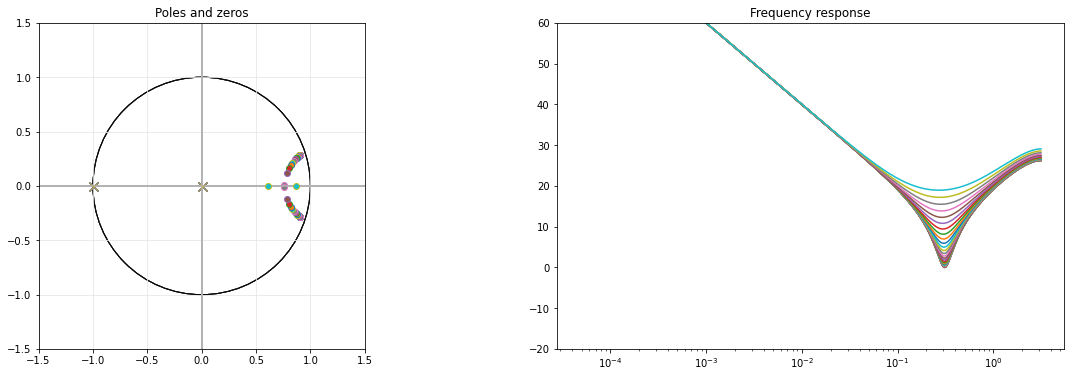

In [8]:
k_i = 0
k_d = 20
k_p = np.arange(-40,20, 2).tolist()

fig, ax = plt.subplots(1,2, figsize=(20,6))
for l in k_p:
    ba = pid(k_i, l, k_d)
    z, p, k = signal.tf2zpk(ba[:3],[1.0]+ba[3:])
    fig, ax[0] = zplane(z, p, ax[0], fig)
    w, h = signal.freqz(ba[:3], [0.999999999999] + [-x for x in ba[3:]], 2 ** 16)
    h = 20 * np.log10(np.abs(h))
    ax[1].plot(w, h)
    ax[1].set_xscale('log')
    ax[1].set_ylim(-20, 60)
    ax[1].set_title('Frequency response')
plt.show()

# sweep ki

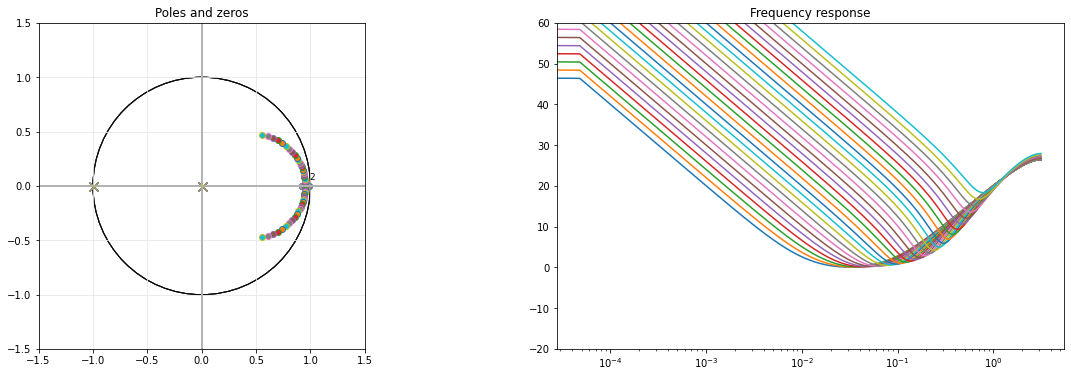

In [9]:
k_i = np.arange(-40,20, 2).tolist()
k_d = 20
k_p = 0

fig, ax = plt.subplots(1,2, figsize=(20,6))
for l in k_i:
    ba = pid(l, k_p, k_d)
    z, p, k = signal.tf2zpk(ba[:3],[1.0]+ba[3:])
    fig, ax[0] = zplane(z, p, ax[0], fig)
    w, h = signal.freqz(ba[:3], [0.999999999999] + [-x for x in ba[3:]], 2 ** 16)
    h = 20 * np.log10(np.abs(h))
    ax[1].plot(w, h)
    ax[1].set_xscale('log')
    ax[1].set_ylim(-20, 60)
    ax[1].set_title('Frequency response')
plt.show()

# sweep kd

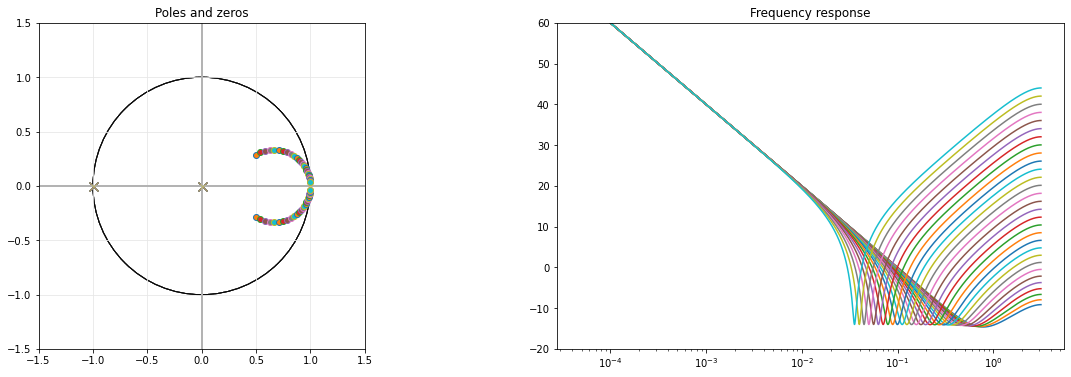

In [10]:
k_i = -20
k_d = np.arange(-20,40, 2).tolist()
k_p = -20

fig, ax = plt.subplots(1,2, figsize=(20,6))
for l in k_d:
    ba = pid(k_i, k_p, l)
    z, p, k = signal.tf2zpk(ba[:3],[1.0]+ba[3:])
    fig, ax[0] = zplane(z, p, ax[0], fig)
    w, h = signal.freqz(ba[:3], [0.999999999999] + [-x for x in ba[3:]], 2 ** 16)
    h = 20 * np.log10(np.abs(h))
    ax[1].plot(w, h)
    ax[1].set_xscale('log')
    ax[1].set_ylim(-20, 60)
    ax[1].set_title('Frequency response')
plt.show()